In [1]:
import time
import numpy as np
from PIL import Image
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import vgg16
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [2]:
# -----------------------------------------------hyperparameters-------------------------------------------------------

height = 512
width = 512
channel = 3

# mean value of imagenet dataset for rgb channel

mean_r = 103.393
mean_g = 116.779
mean_b = 123.68

# defining weights for each type of loss

weight_content = .025
weight_style = 5
weight_variation = 1

# layers to measure loss from, content and feature layers for content and style loss 

content_layer = 'block2_conv2'
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

In [3]:
base_image = Image.open('images/base.jpg')
style_image = Image.open('images/style.jpg')

base_image = base_image.resize((height, width))
style_image = style_image.resize((height, width))

base image:


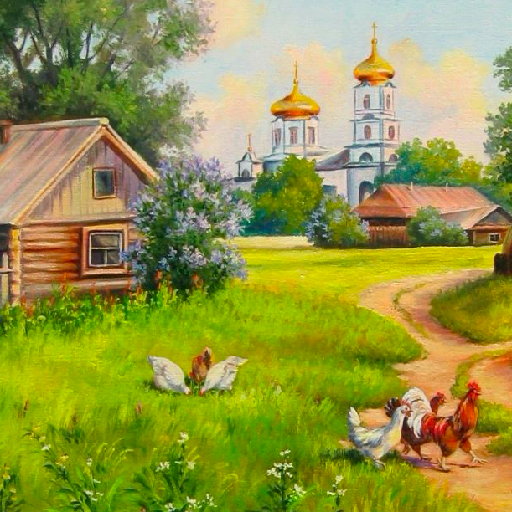

In [4]:
print("base image:")
base_image

style_image:


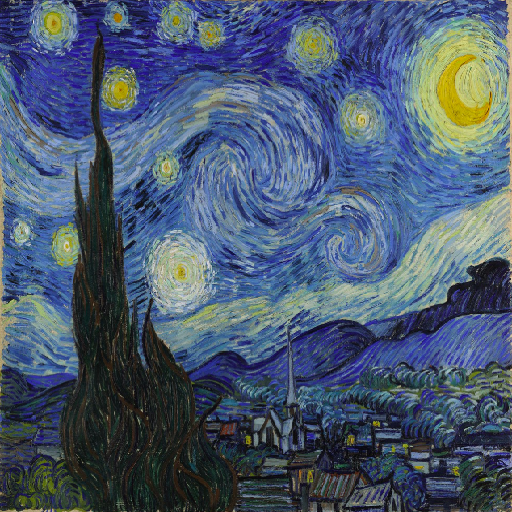

In [5]:
print("style_image:")
style_image

In [6]:
# converting the PIL images to numpy array
# PIL image has 4 channel, 4th channel has all values eual to 255, so removing the 4th channel

base_image = np.array(base_image, dtype=float)
style_image = np.array(style_image, dtype=float)

base_image = base_image[:,:,:channel]
style_image = style_image[:,:,:channel]

In [7]:
# reshaping the array in 4 dimensions

base_image = base_image.reshape((1, height, width, channel))
style_image = style_image.reshape((1, height, width, channel))

In [8]:
# substract the mean and reverse the order of RGB channel since vgg uses this type of data

base_image[:,:,:,0] -= mean_r
base_image[:,:,:,1] -= mean_g
base_image[:,:,:,2] -= mean_b

style_image[:,:,:,0] -= mean_r
style_image[:,:,:,1] -= mean_g
style_image[:,:,:,2] -= mean_b

base_image = base_image[:,:,:,::-1]
style_image = style_image[:,:,:,::-1]

In [9]:
# converting numpy arrays to tensors and defining a placeholder for combined image

base_image = K.variable(base_image)
style_image = K.variable(style_image)
combined_image = K.placeholder((1, height, width, channel))
input_image = K.concatenate([base_image, style_image, combined_image], axis=0)

In [10]:
# loading the pretrained vgg model

model = vgg16.VGG16(include_top=False, input_tensor=input_image, weights='imagenet')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [12]:
layers = dict()

for layer in model.layers:
    
    layers[layer.name] = layer.output

In [13]:
# defining content loss between our base image and target image
# loss is defined by taking eucladian distance between two matrices

def content_loss(content, combined):
    
    loss = K.sum(K.square(content-combined))
    return loss

In [14]:
# defining gram matrix for calculating style loss

def gram(x):
    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [15]:
# defining style loss between style image and target image

def style_loss(style, combined):
    
    s = gram(style)
    c = gram(combined)
    size = width*height
    loss = K.sum(K.square(s-c))/(4.*(channel**2)*(size**2))
    return loss

In [16]:
# defining variance loss for reducing noise in final image

def variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [17]:
# calculate total loss

loss = K.variable(0.)

def total_loss():
    
    global loss
    base_feature = layers[content_layer][0,:,:,:]
    combined_feature = layers['block2_conv2'][2,:,:,:]

    loss = 0
    loss += weight_content*content_loss(base_feature, combined_feature)
        
    for layer in feature_layers:
        
        style_feature = layers[layer][1,:,:,:]
        combined_feature = layers[layer][2,:,:,:]
        s_loss = style_loss(style_feature, combined_feature)
        loss += (weight_style*s_loss)/len(feature_layers)  
    
    loss += weight_variation*variation_loss(combined_image)
    
    return loss

In [18]:
# defining gradient of loss wrt combined image, returns a gradient tensor

loss = total_loss()
grad = K.gradients(loss, combined_image)

In [19]:
output = [loss]
output += grad
fun_output = K.function([combined_image], output)

In [20]:
# function that returns loss and gradient for combined image

def eval_loss_grad(x):
    
    x = x.reshape((1, height, width, 3))
    out = fun_output([x])
    loss = out[0]
    grad = out[1].flatten().astype('float64')
    return loss, grad

In [21]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_grad(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Initial combined image:


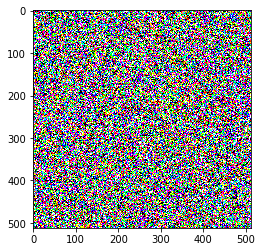

In [22]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

print("\nInitial combined image:")
plt.imshow(x[0])

In [23]:
iterations = 9

for i in range(iterations):
    
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    end_time = time.time()
    print('Current loss value:', min_val)
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))
    print('')

Current loss value: 51258434000.0
Iteration 1 completed in 20s

Current loss value: 19944376000.0
Iteration 2 completed in 13s

Current loss value: 14205151000.0
Iteration 3 completed in 13s

Current loss value: 12446577000.0
Iteration 4 completed in 14s

Current loss value: 11920689000.0
Iteration 5 completed in 14s

Current loss value: 11659602000.0
Iteration 6 completed in 14s

Current loss value: 11494031000.0
Iteration 7 completed in 14s

Current loss value: 11375791000.0
Iteration 8 completed in 14s

Current loss value: 11282583000.0
Iteration 9 completed in 14s



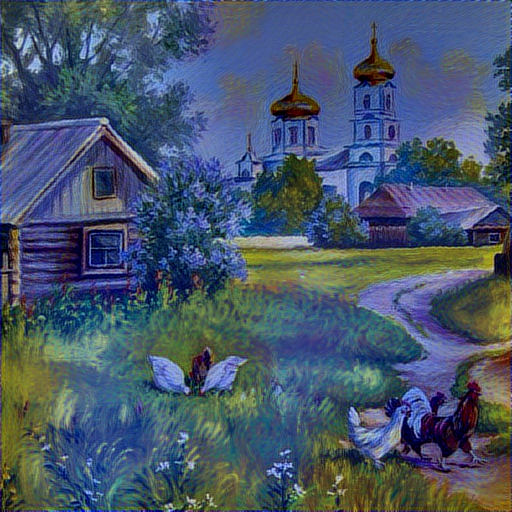

In [24]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += mean_r
x[:, :, 1] += mean_g
x[:, :, 2] += mean_b
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)